# Premier League 2023–24 — Exploratory Data Analysis for Predictive Modeling

This notebook lays out a PhD-level, modular EDA pipeline. We will:

1. Import only the columns we need  
2. Check data integrity (types, non-null counts)  
3. Parse and categorize match time  
4. Build core target & goal/odds-based features  
5. (Later) add historical, interaction & dynamic ranking features  

_No train/test split or scaling yet — pure EDA._


In [12]:
# %% 
# 1.1 Imports & Column Selection
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Only these columns are read from disk:
usecols = [
    'Time',
    'HomeTeam', 'AwayTeam',
    'FTHG', 'FTAG', 'FTR',
    'Referee',
    'HS','AS','HST','AST',
    'HF','AF','HC','AC',
    'HY','AY','HR','AR',
    'B365H','B365D','B365A',
    'B365>2.5','B365>2.5'
]

file_path = r"D:\python\premier league predictor\premier league data\premier leaguer 23-24.csv"
df = pd.read_csv(file_path, usecols=usecols)


## 1.2 Quick Data Integrity Checks

We ensure types and non-null counts are as expected.  If any missing values appear in our `usecols`, they will be reported here.


In [13]:
# %%
print("Dataset shape:", df.shape)
print("\nColumn types & non-null counts:")
print(df.info())

print("\nMissing values per column:")
print(df.isnull().sum())


Dataset shape: (380, 23)

Column types & non-null counts:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 380 entries, 0 to 379
Data columns (total 23 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Time      380 non-null    object 
 1   HomeTeam  380 non-null    object 
 2   AwayTeam  380 non-null    object 
 3   FTHG      380 non-null    int64  
 4   FTAG      380 non-null    int64  
 5   FTR       380 non-null    object 
 6   Referee   380 non-null    object 
 7   HS        380 non-null    int64  
 8   AS        380 non-null    int64  
 9   HST       380 non-null    int64  
 10  AST       380 non-null    int64  
 11  HF        380 non-null    int64  
 12  AF        380 non-null    int64  
 13  HC        380 non-null    int64  
 14  AC        380 non-null    int64  
 15  HY        380 non-null    int64  
 16  AY        380 non-null    int64  
 17  HR        380 non-null    int64  
 18  AR        380 non-null    int64  
 19  B365H     380

## 1.3 Parse Match Time & Create Time Category

We extract the hour from `Time` and bucket into Morning/Afternoon/Evening.  
We then discard the raw `Time` string.


In [14]:
# %%
# Extract hour
df['MatchHour'] = pd.to_datetime(df['Time'], format='%H:%M', errors='coerce').dt.hour

# Bin into three time-of-day categories
bins = [-1, 11, 17, 24]
labels = ['Morning', 'Afternoon', 'Evening']
df['TimeOfDay'] = pd.cut(df['MatchHour'], bins=bins, labels=labels)

# Drop intermediate columns
df.drop(columns=['Time', 'MatchHour'], inplace=True)

# Inspect new column
print(df[['TimeOfDay']].head())


   TimeOfDay
0    Evening
1  Afternoon
2  Afternoon
3  Afternoon
4  Afternoon


## 1.4 Core Goal & Odds Features

We derive fundamental match‐level features:

1. `TotalGoals`, `GoalDifference`, `DominanceIndex`, `Over2.5Goals`  
2. Implicit win/draw/loss probabilities from B365 odds  
3. `Outcome` coded as 1 (H win), 0 (draw), –1 (A win)  


In [15]:
# %% 
# 1) Goals-based metrics
df['TotalGoals']     = df['FTHG'] + df['FTAG']
df['GoalDifference'] = df['FTHG'] - df['FTAG']
df['DominanceIndex'] = df['GoalDifference'] / (df['TotalGoals'] + 1)
df['Over2.5Goals']   = (df['TotalGoals'] >= 3).astype(int)

# 2) Implicit probabilities
df['ImpProb_H'] = 1.0 / df['B365H']
df['ImpProb_D'] = 1.0 / df['B365D']
df['ImpProb_A'] = 1.0 / df['B365A']
# normalize row-wise
prob_cols = ['ImpProb_H','ImpProb_D','ImpProb_A']
df[prob_cols] = df[prob_cols].div(df[prob_cols].sum(axis=1), axis=0)

# 3) Outcome mapping
df['Outcome'] = df['FTR'].map({'H':1, 'D':0, 'A':-1})

# Inspect
print(df[['TotalGoals','GoalDifference','DominanceIndex','Over2.5Goals']].head())
print(df[prob_cols + ['Outcome']].head())


   TotalGoals  GoalDifference  DominanceIndex  Over2.5Goals
0           3              -3           -0.75             1
1           3               1            0.25             1
2           2               0            0.00             0
3           5               3            0.50             1
4           1              -1           -0.50             0
   ImpProb_H  ImpProb_D  ImpProb_A  Outcome
0   0.118070   0.171738   0.710193       -1
1   0.801772   0.135156   0.063073        1
2   0.350515   0.278351   0.371134        0
3   0.719634   0.174020   0.106346        1
4   0.432203   0.279661   0.288136       -1


## 2. Historical Features: Rolling Averages & Win Streaks

We assume `df` is in match order. We’ll:

- Assign a global `MatchIndex`  
- Compute 3-match rolling goal averages per team  
- Compute consecutive win‐streak lengths  


In [16]:
# %% 
# 2.1 MatchIndex
df = df.reset_index(drop=True)
df['MatchIndex'] = df.index + 1

# 2.2 3-match rolling goals
df['HomeGoalsAvg3'] = (
    df.groupby('HomeTeam')['FTHG']
      .transform(lambda x: x.rolling(3, min_periods=1).mean())
)
df['AwayGoalsAvg3'] = (
    df.groupby('AwayTeam')['FTAG']
      .transform(lambda x: x.rolling(3, min_periods=1).mean())
)

# 2.3 Win streaks
df['HomeWinStreak'] = (
    df.groupby('HomeTeam')['Outcome']
      .transform(lambda s: 
          s.eq(1).astype(int)
           .groupby((~s.eq(1)).cumsum())
           .cumsum()
      )
)
df['AwayWinStreak'] = (
    df.groupby('AwayTeam')['Outcome']
      .transform(lambda s: 
          s.eq(-1).astype(int)
           .groupby((~s.eq(-1)).cumsum())
           .cumsum()
      )
)

# Quick peek
print(df[['HomeTeam','FTHG','HomeGoalsAvg3','HomeWinStreak']].head(6))


           HomeTeam  FTHG  HomeGoalsAvg3  HomeWinStreak
0           Burnley     0            0.0              0
1           Arsenal     2            2.0              1
2       Bournemouth     1            1.0              0
3          Brighton     4            4.0              1
4           Everton     0            0.0              0
5  Sheffield United     0            0.0              0


## 3. Interaction Features

Combine odds and form metrics:

- `OddsSpread` = B365H – B365A  
- `OddsGoalInteraction` = OddsSpread × DominanceIndex  
- `OddsFormInteraction` = OddsSpread × HomeGoalsAvg3  


In [17]:
# %% 
df['OddsSpread']         = df['B365H'] - df['B365A']
df['OddsGoalInteraction'] = df['OddsSpread'] * df['DominanceIndex']
df['OddsFormInteraction'] = df['OddsSpread'] * df['HomeGoalsAvg3']

print(df[['OddsSpread','OddsGoalInteraction','OddsFormInteraction']].head())


   OddsSpread  OddsGoalInteraction  OddsFormInteraction
0        6.67              -5.0025                 0.00
1      -13.82              -3.4550               -27.64
2        0.15               0.0000                 0.15
3       -7.67              -3.8350               -30.68
4       -1.10               0.5500                -0.00


## 4. Dynamic Table Position

We compute running points, cumulative points and position at each `MatchIndex`.  


In [18]:
# %% 
# 4.1 Points per match
df['Points_Home'] = df['Outcome'].map({1:3, 0:1, -1:0})
df['Points_Away'] = df['Outcome'].map({1:0, 0:1, -1:3})

# 4.2 Cumulative points by team
df['CumulPoints_H'] = df.groupby('HomeTeam')['Points_Home'].cumsum()
df['CumulPoints_A'] = df.groupby('AwayTeam')['Points_Away'].cumsum()

# 4.3 Table position at each match
df['TablePos_Home'] = df.groupby('MatchIndex')['CumulPoints_H']\
                         .rank(method='min', ascending=False)
df['TablePos_Away'] = df.groupby('MatchIndex')['CumulPoints_A']\
                         .rank(method='min', ascending=False)

print(df[['MatchIndex','HomeTeam','CumulPoints_H','TablePos_Home']].head())


   MatchIndex     HomeTeam  CumulPoints_H  TablePos_Home
0           1      Burnley              0            1.0
1           2      Arsenal              3            1.0
2           3  Bournemouth              1            1.0
3           4     Brighton              3            1.0
4           5      Everton              0            1.0


## 5. Visualizations

### 5.1 Distribution of Key Features


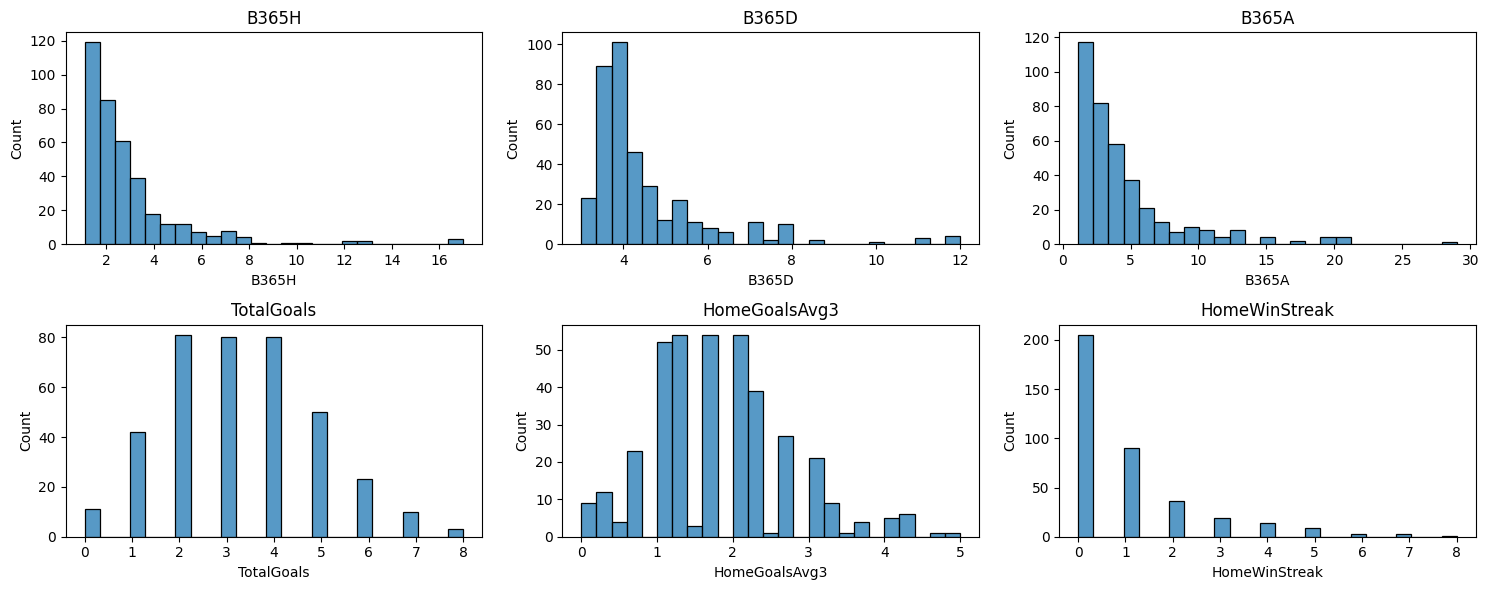

In [19]:
# %%
vars_to_plot = ['B365H','B365D','B365A','TotalGoals','HomeGoalsAvg3','HomeWinStreak']
plt.figure(figsize=(15,6))
for i, col in enumerate(vars_to_plot, 1):
    plt.subplot(2, 3, i)
    sns.histplot(df[col], bins=25, kde=False)
    plt.title(col)
plt.tight_layout()
plt.show()


### 5.2 Correlation Clustermap


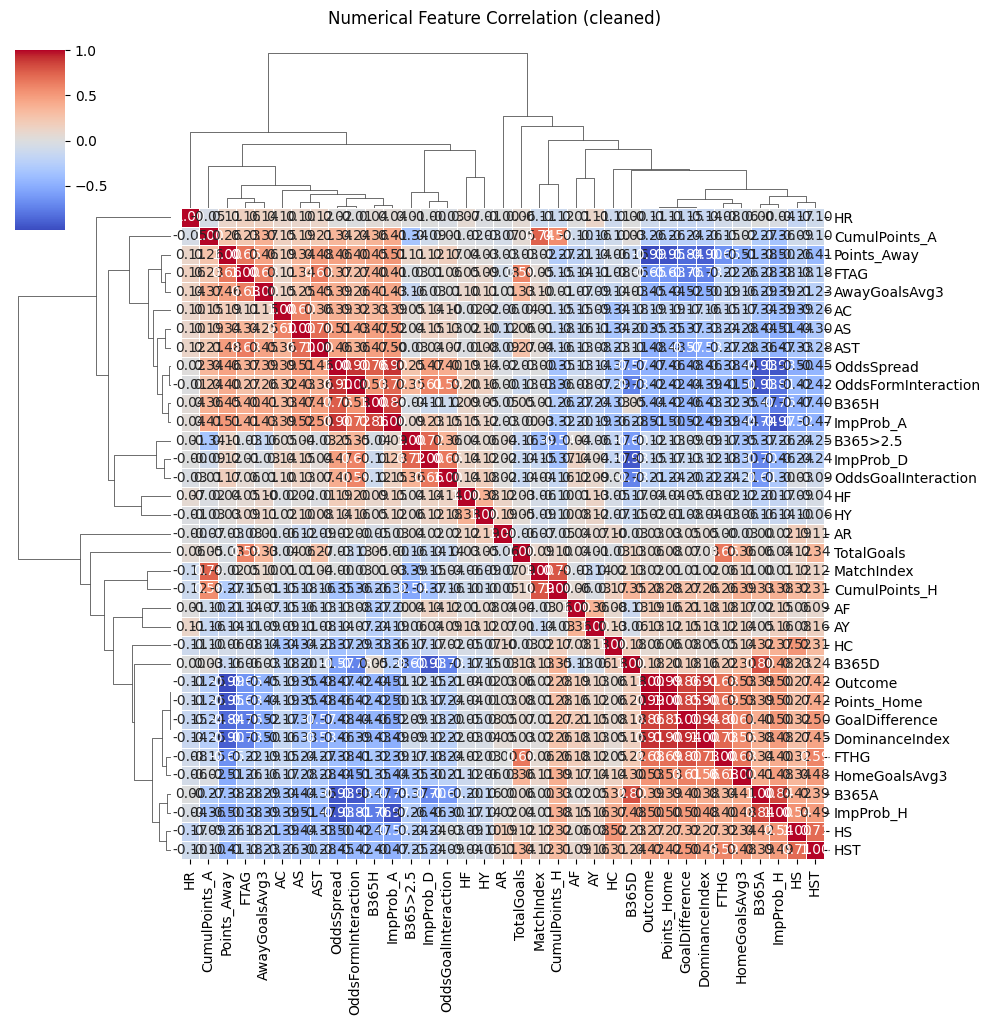

In [20]:
# %%
# 1) Fill NaNs in historical features before corr
for col in ['HomeGoalsAvg3','AwayGoalsAvg3','HomeWinStreak','AwayWinStreak']:
    if col in df.columns:
        df[col] = df[col].fillna(0)

# 2) Select numeric cols and drop constant ones
num_df = df.select_dtypes(include=['int64','float64']).copy()
vars_   = num_df.var()
good    = vars_[vars_ > 0].index
num_df  = num_df[good]

# 3) Compute corr, replace inf/NaN with zero
corr = num_df.corr().replace([np.inf, -np.inf], np.nan).fillna(0)

# 4) Plot cleaned clustermap
sns.clustermap(
    corr,
    cmap='coolwarm',
    annot=True, fmt=".2f",
    figsize=(10,10),
    method='average',
    metric='correlation',
    linewidths=0.5
)
plt.suptitle("Numerical Feature Correlation (cleaned)", y=1.02)
plt.show()

### 5.3 PCA Scatter (2 Components)


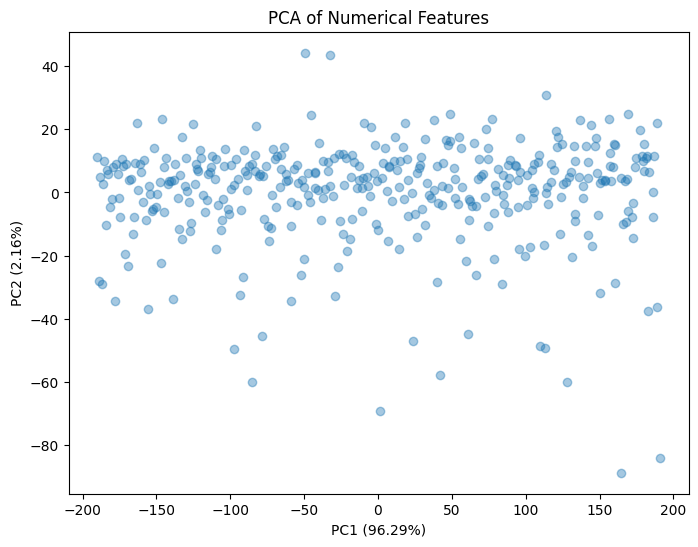

In [21]:
# %%
from sklearn.decomposition import PCA

Xnum = df.select_dtypes(include=['int64','float64']).copy()
pca = PCA(n_components=2, random_state=42)
pcs = pca.fit_transform(Xnum)
exp_var = np.round(pca.explained_variance_ratio_*100, 2)

plt.figure(figsize=(8,6))
plt.scatter(pcs[:,0], pcs[:,1], alpha=0.4)
plt.xlabel(f'PC1 ({exp_var[0]}%)')
plt.ylabel(f'PC2 ({exp_var[1]}%)')
plt.title("PCA of Numerical Features")
plt.show()


## 6. Pairwise Relationships: Pairplot

We now explore bivariate relationships among a small set of core numerical features.  
We choose those with high variance or model‐interest:  
- Odds (`B365H`,`B365D`,`B365A`)  
- Goal metrics (`TotalGoals`,`GoalDifference`)  
- Form indicators (`HomeGoalsAvg3`,`HomeWinStreak`)  

_Diagonal shows KDE estimates; off‐diagonals show scatter + low‐opacity._  


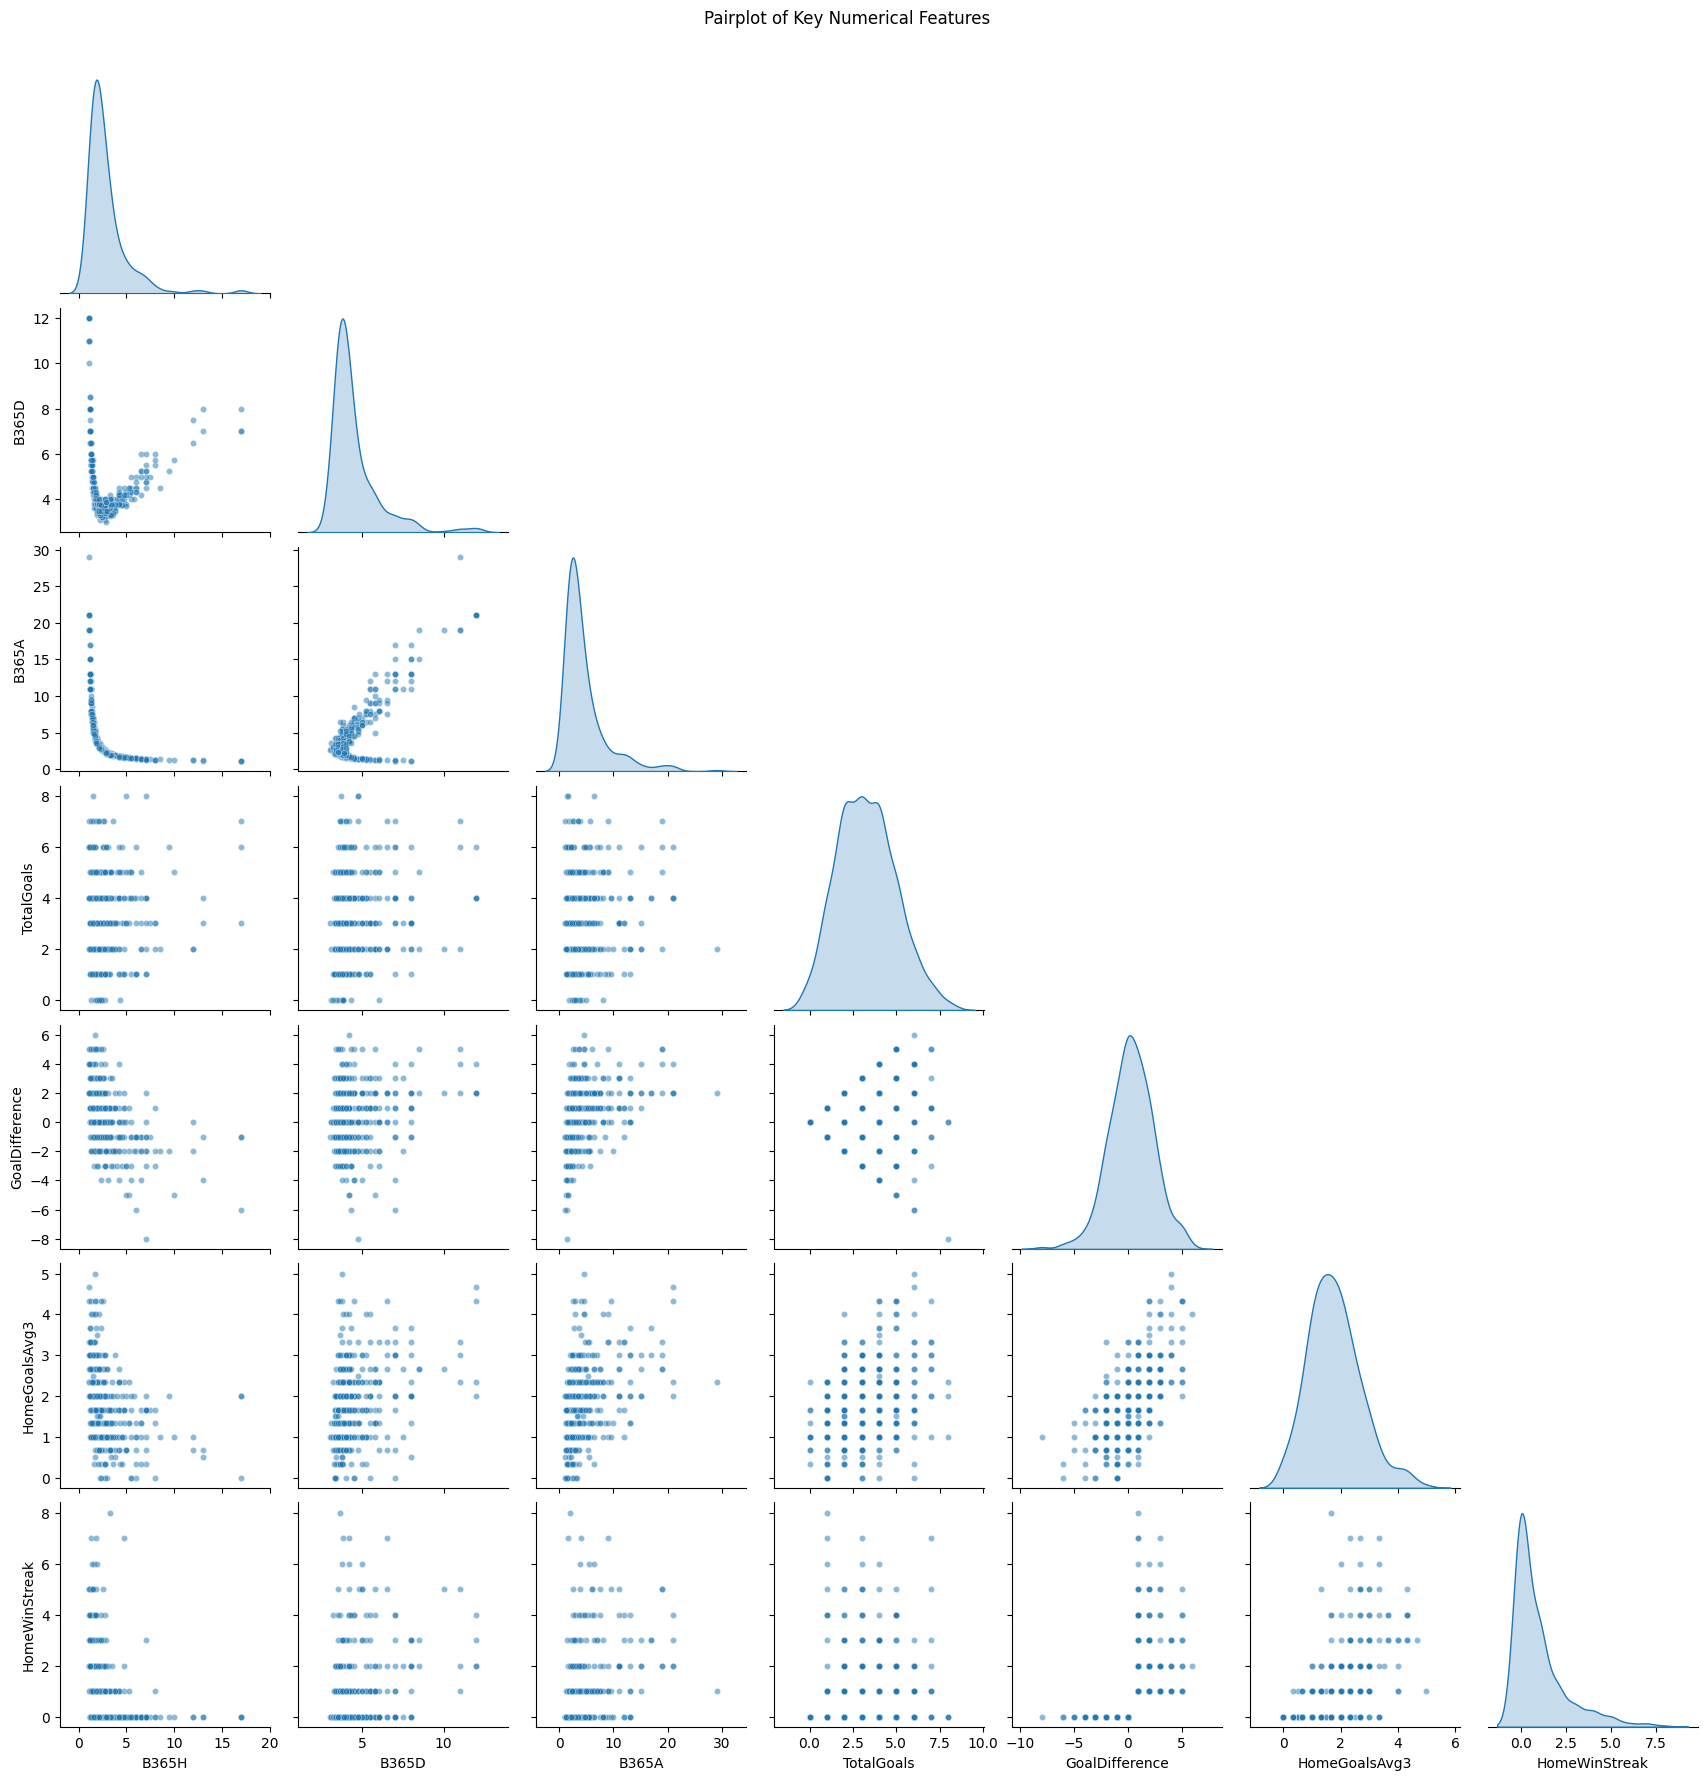

In [22]:
# %% 
# 6.1 Select variables for pairplot
vars_for_pairplot = [
    'B365H','B365D','B365A',
    'TotalGoals','GoalDifference',
    'HomeGoalsAvg3','HomeWinStreak'
]

# 6.2 Plot
sns.pairplot(
    df[vars_for_pairplot],
    corner=True,            # only lower triangle
    diag_kind='kde',
    plot_kws={'alpha':0.5, 's':20}
)
plt.suptitle("Pairplot of Key Numerical Features", y=1.02)
plt.show()


## 7. Cluster Analysis: Elbow Method

We test KMeans on our numerical feature space to see natural groupings.  
Using `inertia_` vs. `k` gives the “elbow” where adding clusters yields diminishing returns.  


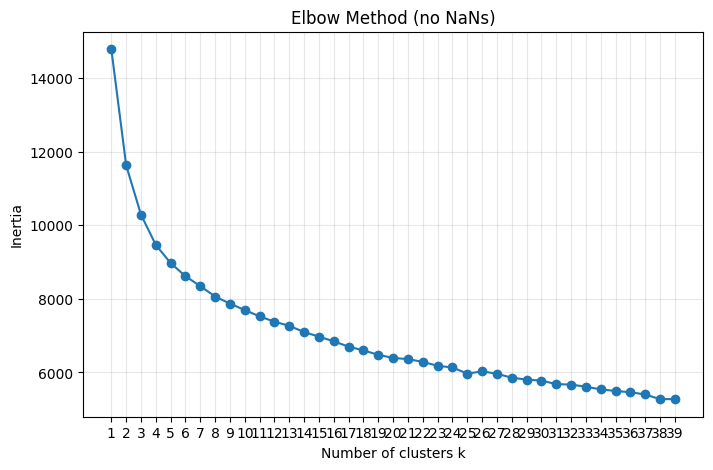

In [25]:
# %% 
from sklearn.cluster import KMeans

# 1) Select numeric columns and drop any constant ones
Xclust = df.select_dtypes(include=[np.number]).copy()
vars_   = Xclust.var()
good    = vars_[vars_ > 0].index
Xclust  = Xclust[good]

# 2) Fill any remaining NaNs with zero
Xclust = Xclust.fillna(0)

# 3) (Optional) Standardize so features are on comparable scales
Xclust = (Xclust - Xclust.mean()) / Xclust.std()

# 4) Compute distortions for k=1…10
distortions = []
K = range(1, 40)
for k in K:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(Xclust)
    distortions.append(km.inertia_)

# 5) Plot the elbow curve
plt.figure(figsize=(8, 5))
plt.plot(K, distortions, 'o-', markersize=6)
plt.xlabel('Number of clusters k')
plt.ylabel('Inertia')
plt.title('Elbow Method (no NaNs)')
plt.xticks(K)
plt.grid(alpha=0.3)
plt.show()

## 8. Time‐Series Trend: Rolling Total Goals

Even without explicit dates, our `MatchIndex` gives an ordered timeline.  
We compute a 5‐match moving average of `TotalGoals` to see scoring trends.  


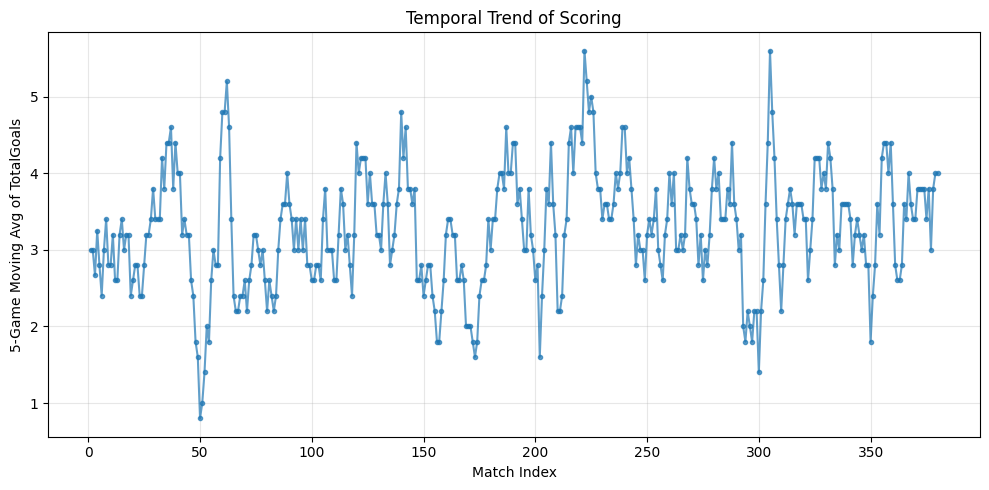

In [24]:
# %% 
# 8.1 Rolling average (window=5)
df['Rolling5_TotalGoals'] = df['TotalGoals'].rolling(window=5, min_periods=1).mean()

# 8.2 Plot trend
plt.figure(figsize=(10,5))
plt.plot(df['MatchIndex'], df['Rolling5_TotalGoals'], marker='.', alpha=0.7)
plt.xlabel('Match Index')
plt.ylabel('5-Game Moving Avg of TotalGoals')
plt.title('Temporal Trend of Scoring')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


---
### Next Steps

1. **Feature Selection:** use PCA loadings or univariate filters to prune low‐impact variables.  
2. **Model‐specific Pipelines:** integrate these features into sklearn `ColumnTransformer` + model.  
3. **Hyperparameter Search & Validation:** set up time‐series–aware cross‐validation.  

This completes the core EDA: from raw data through goal/odds features, history, interactions, clustering, and trend analysis.  
Proceed to build and benchmark predictive models on **TotalGoals** and **Outcome**.  
